In [96]:
# !pip install neattext
# !pip install wordcloud
# !pip install nltk

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from wordcloud import WordCloud
import neattext.functions as nfx
import nltk
from nltk.corpus import stopwords
import re

import neattext as nt

In [98]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [99]:
print('Train data shape:', train_df.shape)
print('Train columns:', train_df.columns)
print('Test data shape:', test_df.shape)
print('Test columns:', test_df.columns)

Train data shape: (7613, 5)
Train columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Test data shape: (3263, 4)
Test columns: Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [100]:
train_df = train_df.drop(['id'], axis = 1)
test_df = test_df.drop(['id'], axis = 1)

In [101]:
print('Number of duplicated text on train data: ',train_df.duplicated(['text']).sum())
print('Number of duplicated text on test data: ',test_df.duplicated(['text']).sum())

Number of duplicated text on train data:  110
Number of duplicated text on test data:  20


In [102]:
train_df[train_df['text'].duplicated() == True].sort_values(by=['text'])

,keyword,location,text,target
4299,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...
3461,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,sinking,MA,that horrible sinking feeling when youÛªve be...,1


In [103]:
train_df = train_df.drop_duplicates(subset=['text'])
train_df

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7604,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


In [104]:
def missing_ratio(_df):
    missing_cols = _df.columns[_df.isnull().any()]
    plt.subplots(figsize=(6, 6))
    missing_ratio = _df[missing_cols].isnull().sum() * 100 / len(_df)
    missing_ratio.sort_values(inplace=True)
    missing_ratio.plot.bar(missing_ratio)
    return missing_ratio

keyword      0.746368
location    33.080101
dtype: float64

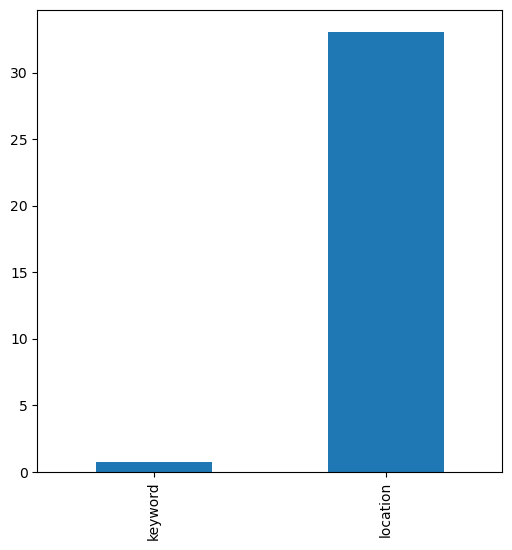

In [105]:
train_missing = missing_ratio(train_df)
train_missing

keyword      0.796813
location    33.864542
dtype: float64

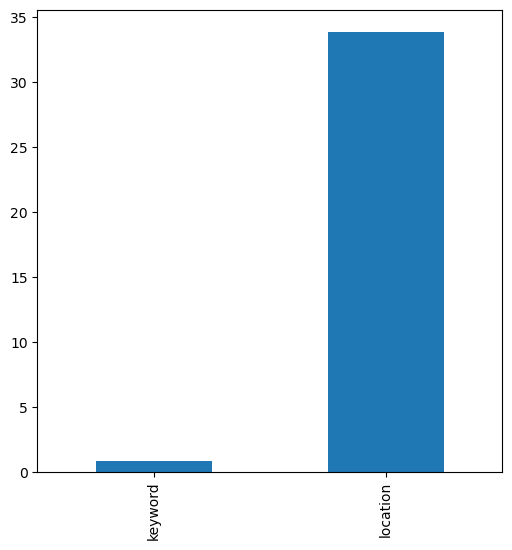

In [106]:
test_missing = missing_ratio(test_df)
test_missing

In [107]:
for col in ['keyword','location']:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

In [108]:
def clean_text(text):
    text = re.sub(r"(?:\@)\S+", "", text)
    text = text.lower()
    docx = nt.TextFrame(text=text)
    docx.normalize()
    docx.remove_urls()
    docx.remove_emojis()
    docx.remove_emails()
    docx.remove_puncts()
    docx.remove_special_characters()
    docx.remove_numbers()
    docx.remove_stopwords()
    docx.fix_contractions()
    return docx.text

In [109]:
train_df['text']=train_df['text'].apply(lambda x: clean_text(x))
test_df['text']=test_df['text'].apply(lambda x: clean_text(x))

In [110]:
train_df['text']

0                   deeds reason earthquake allah forgive
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7604    worldnews fallen powerlines glink tram update ...
7605        flip im walmart bomb evacuate stay tuned blow
7606    suicide bomber kills saudi security site mosqu...
7608    giant cranes holding bridge collapse nearby homes
7612    latest homes razed northern california wildfir...
Name: text, Length: 7503, dtype: object

In [111]:
test_df['text']

0                             happened terrible car crash
1             heard earthquake different cities stay safe
2         forest fire spot pond geese fleeing street save
3                   apocalypse lighting spokane wildfires
4                     typhoon soudelor kills china taiwan
                              ...                        
3258    earthquake safety los angeles safety fasteners...
3259    storm ri worse hurricane cityampothers hardest...
3260                        green line derailment chicago
3261             meg issues hazardous weather outlook hwo
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

## Khám phá dữ liệu

In [112]:
count_target = train_df.groupby("target").count()
count_target = count_target.rename(columns={"text": "count"})
fig = px.bar(count_target, x=count_target.index, y='count')
fig.update_layout(xaxis={'type': 'category'}, title={
            'text': 'Phân bố cột target',
            'x': 0.5,  # Giữa trục x
            'xanchor': 'center',  # Căn giữa theo trục x
            'yanchor': 'top'  # Căn theo trục y
        })
fig.show()

In [113]:
top_key_word = train_df.groupby(["keyword"])["target"].mean().reset_index().sort_values(by = 'target', ascending=False)
top_key_word = top_key_word["keyword"]
# Separate the top_key_word into head and tail keywords
head_key_word = top_key_word.head(10)
tail_key_word = top_key_word.tail(10)

target_by_keyword = train_df.groupby(["keyword", "target"])["text"].count().reset_index()
target_by_keyword = target_by_keyword.rename(columns={"text": "count"})
target_by_keyword = target_by_keyword.sort_values(by=["target", "count"], ascending=[True, False])
target_by_keyword['target'] = target_by_keyword['target'].astype(object)

from plotly.subplots import make_subplots


# Filter the target_by_keyword DataFrame based on head and tail keywords
head_data = target_by_keyword[target_by_keyword["keyword"].isin(head_key_word)]
tail_data = target_by_keyword[target_by_keyword["keyword"].isin(tail_key_word)]

# Create the subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 10 High Probability Keywords", "Top 10 Low Probability Keywords"))

# Plot the first subplot (top 10 high probability keywords)
fig.add_trace(px.bar(head_data, x="keyword", y='count', color = "target").data[0], row=1, col=1)
fig.add_trace(px.bar(head_data, x="keyword", y='count', color = "target").data[1], row=1, col=1)

# Plot the second subplot (top 10 low  probability keywords)
fig.add_trace(px.bar(tail_data, x="keyword", y='count', color = "target").data[0], row=1, col=2)
fig.add_trace(px.bar(tail_data, x="keyword", y='count', color = "target").data[1], row=1, col=2)

# Update the layout
fig.update_layout(
    xaxis=dict(type='category'),
    showlegend=True,
    barmode='stack'
    
)

fig.update_traces(showlegend=True, row=1, col=1)  
fig.update_traces(showlegend=False, row=1, col=2)  

# Show the figure

fig.show()

In [114]:
top_location = train_df.groupby("location")["target"].count().sort_values(ascending=False).head(20)


fig = px.bar(top_location, x=top_location.index, y=top_location.values)
fig.update_layout(xaxis={'type': 'category'}, 
                yaxis_title = "Số lượng tweet",
                xaxis_title = "Địa điểm",
                title={
                    'text': 'Top 20 địa điểm có nhiều tweet nhất',
                    'x': 0.5,  # Giữa trục x
                    'xanchor': 'center',  # Căn giữa theo trục x
                    'yanchor': 'top'  # Căn theo trục y
                })


fig.show()



In [115]:
top_location

location
None               2482
USA                 104
New York             71
United States        50
London               45
Canada               29
Los Angeles, CA      26
UK                   26
Nigeria              23
India                21
Washington, DC       21
Mumbai               20
Kenya                20
Worldwide            19
Chicago, IL          18
Australia            18
California           17
California, USA      15
New York, NY         15
Everywhere           15
Name: target, dtype: int64

Nhận xét: Có một số địa điểm vốn là giống nhau nhưng lại chia thành 2 tên khác nhau như USA, United States... Chúng ta cần gộp những địa điểm này lại thành 1. Vì số lượng quá nhiều nên chúng tôi chỉ xử lý những địa điểm nổi bật, còn lại sẽ gộp chung thành địa điểm "Others"

In [116]:
def clean_location(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x or 'NY' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Kenya' in x:
        return 'Kenya'
    elif x in top_location.index:
        return x
    else: return 'Others'
    
train_df['location'] = train_df['location'].apply(lambda x: clean_location(str(x)))
test_df['location'] = test_df['location'].apply(lambda x: clean_location(str(x)))

In [117]:
location_df = train_df[train_df["location"].isin(top_location.index)]
location_target = location_df.groupby("location")["target"].mean().sort_values(ascending=False)
mean_target = train_df["target"].mean()

fig = go.Figure()

fig.add_trace(go.Bar(
    x=location_target.index,
    y=location_target.values,
    name="Target trung bình"
))

fig.add_shape(
    type="line",
    x0=-0.5,
    y0=mean_target,
    x1=len(location_target) - 0.5,
    y1=mean_target,
    line=dict(
        color="red",
        width=2,
        dash="dash"
    )
)

fig.update_layout(
    xaxis={'type': 'category'},
    yaxis_title="Target",
    xaxis_title="Địa điểm",
    title={
        'text': 'Target trung bình của các địa phương có nhiều tweet nhất',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

Nhận xét: Ghép mấy cái thành phố
THêm đường tham chiếu

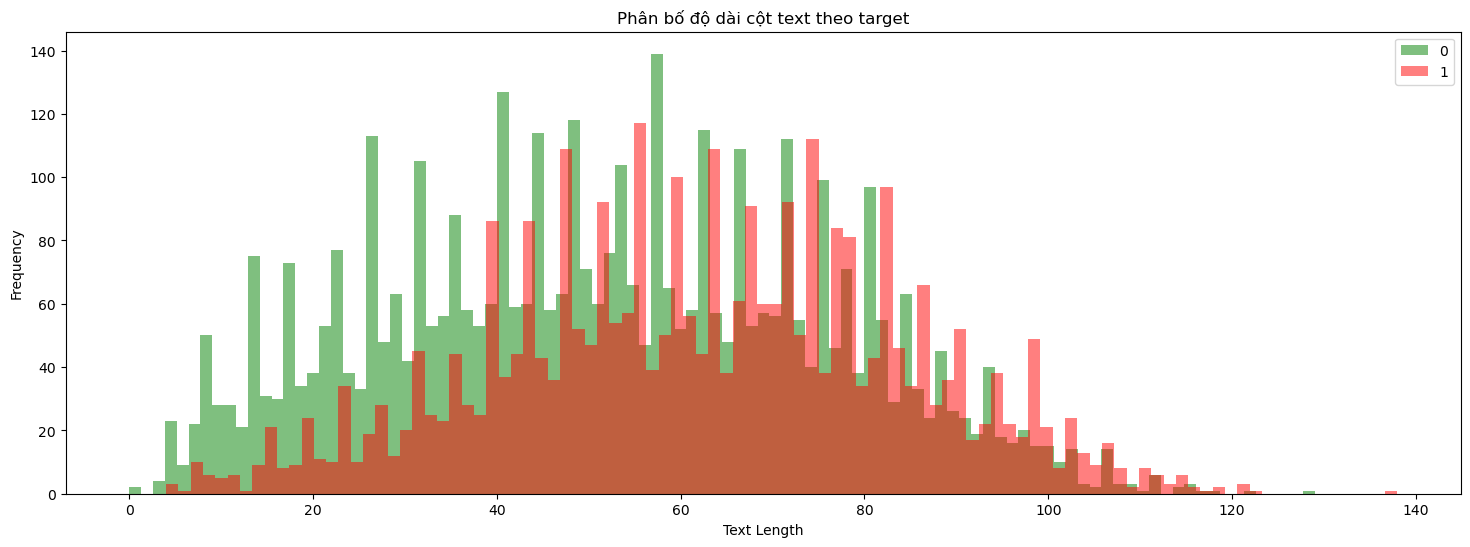

In [126]:
df_with_text_length = train_df.copy()
df_with_text_length['text_length'] = df_with_text_length['text'].apply(len)


# Tách dữ liệu cho mỗi target
target_0 = df_with_text_length[df_with_text_length['target'] == 0]['text_length']
target_1 = df_with_text_length[df_with_text_length['target'] == 1]['text_length']

# Vẽ histogram
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.hist(target_0, bins=100, alpha=0.5, label='0', color = "green")
plt.hist(target_1, bins=100, alpha=0.5, label='1', color = "red")

# Đặt tên trục và tiêu đề
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title("Phân bố độ dài cột text theo target")

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

## CHỉnh màu cho histogram

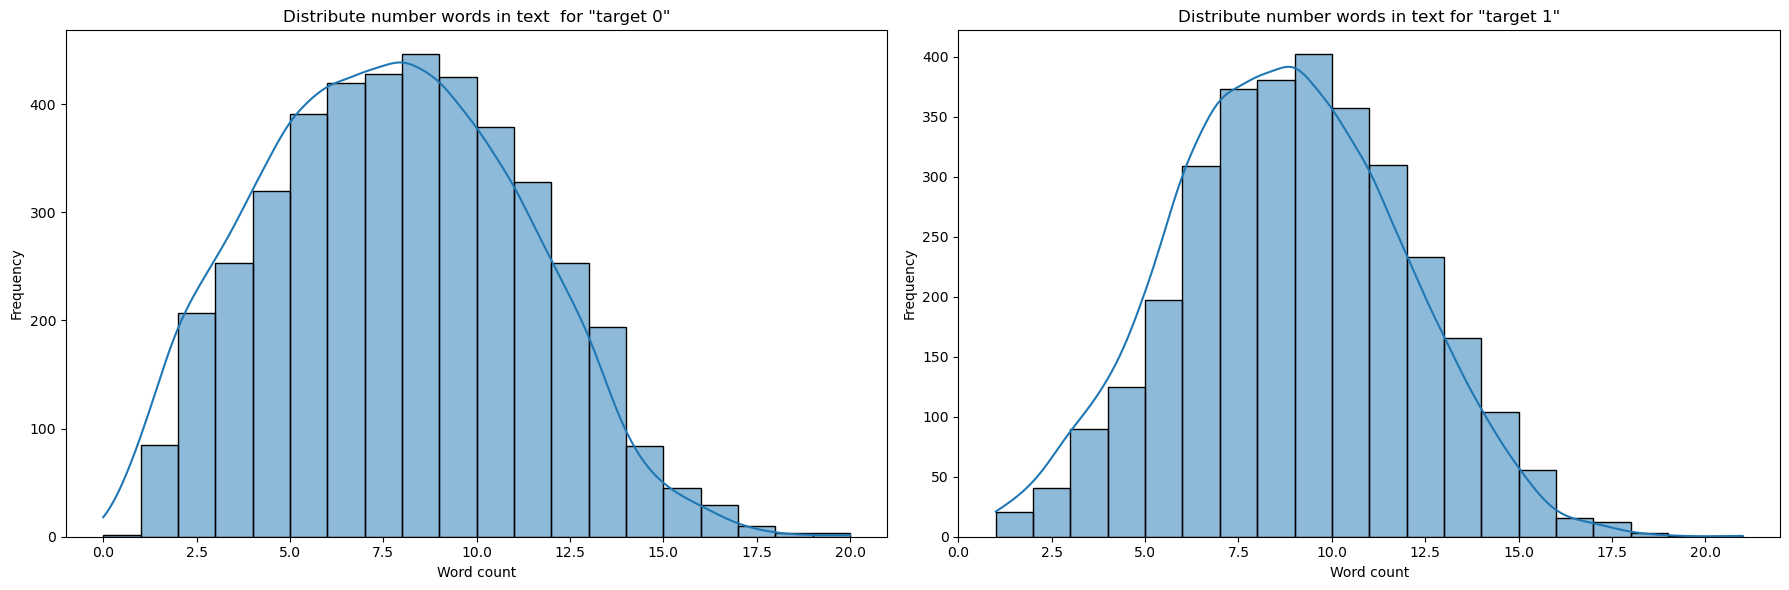

In [119]:

df_with_word_count = train_df.copy()
df_with_word_count['word_count'] = train_df['text'].str.split().map(lambda x: len(x))


fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data=df_with_word_count[df_with_word_count['target'] == 0], x='word_count', bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribute number words in text  for "target 0"')
axes[0].set_xlabel('Word count')
axes[0].set_ylabel('Frequency')

sns.histplot(data=df_with_word_count[df_with_word_count['target'] == 1], x='word_count', bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribute number words in text for "target 1"')
axes[1].set_xlabel('Word count')
axes[1].set_ylabel('Frequency')

# Hiển thị biểu đồ
plt.tight_layout()

plt.show()

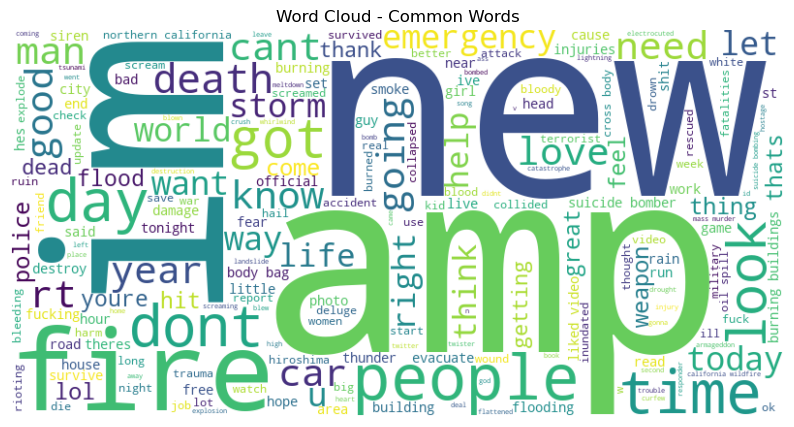

In [120]:
# Tạo một chuỗi từ tất cả các câu trong cột "text"
text_combined = ' '.join(train_df['text'])

# Khởi tạo đối tượng WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Vẽ word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Common Words')
plt.show()

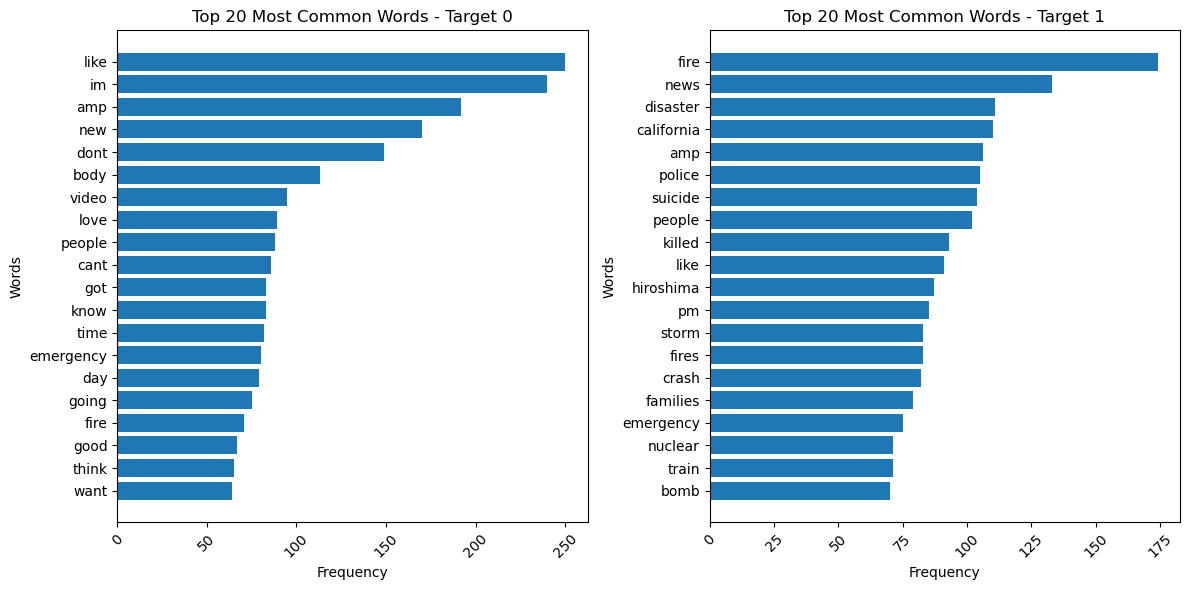

In [132]:
import matplotlib.pyplot as plt
from collections import Counter

# Tách các từ trong cột "text" với target = 0
words_0 = train_df['text'][train_df["target"] == 0].str.split()
all_words_0 = [word for sublist in words_0 for word in sublist]
word_counts_0 = Counter(all_words_0)
top_20_words_0 = word_counts_0.most_common(20)
word_list_0, word_count_0 = zip(*top_20_words_0)
word_list_0, word_count_0 = zip(*sorted(zip(word_list_0, word_count_0), key=lambda x: x[1], reverse=False))


# Tách các từ trong cột "text" với target = 1
words_1 = train_df['text'][train_df["target"] == 1].str.split()
all_words_1 = [word for sublist in words_1 for word in sublist]
word_counts_1 = Counter(all_words_1)
top_20_words_1 = word_counts_1.most_common(20)
word_list_1, word_count_1 = zip(*top_20_words_1)
word_list_1, word_count_1 = zip(*sorted(zip(word_list_1, word_count_1), key=lambda x: x[1], reverse=False))

# Vẽ biểu đồ subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ cho target = 0
axes[0].barh(word_list_0, word_count_0)
axes[0].set_title('Top 20 Most Common Words - Target 0')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ cho target = 1
axes[1].barh(word_list_1, word_count_1)
axes[1].set_title('Top 20 Most Common Words - Target 1')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


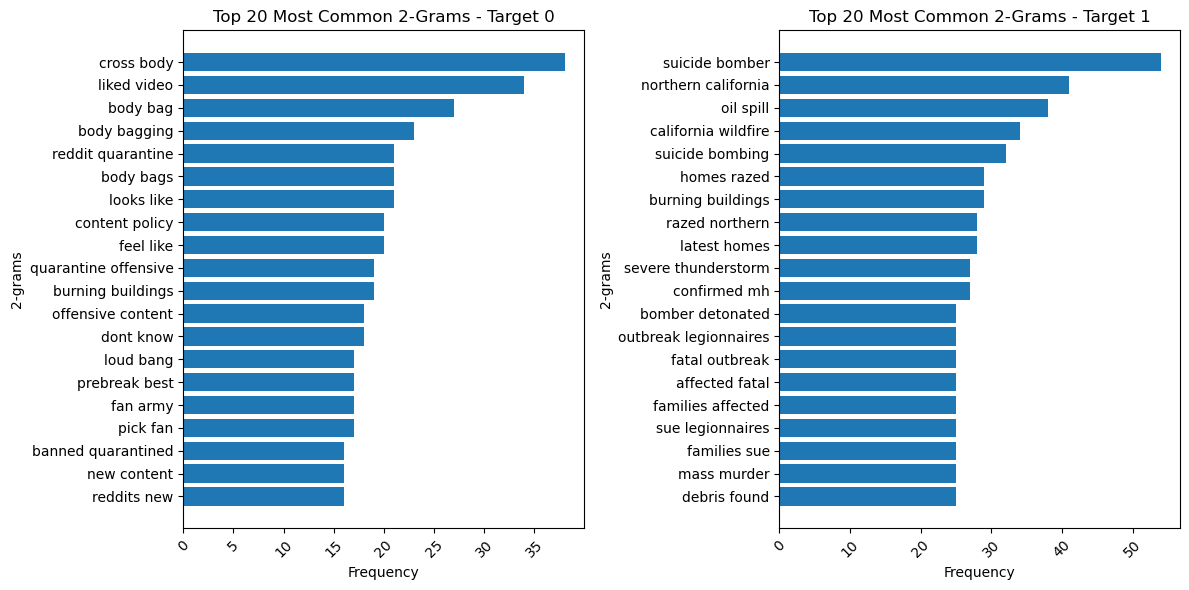

In [133]:
import matplotlib.pyplot as plt
from collections import Counter

# Tách các từ trong cột "text" với target = 0 thành 2-gram
words_0 = train_df['text'][train_df["target"] == 0].str.split()
two_grams_0 = [word for sublist in words_0 for word in zip(sublist[:-1], sublist[1:])]
all_two_grams_0 = [' '.join(gram) for gram in two_grams_0]
two_gram_counts_0 = Counter(all_two_grams_0)
top_20_two_grams_0 = two_gram_counts_0.most_common(20)
two_gram_list_0, two_gram_count_0 = zip(*top_20_two_grams_0)
two_gram_list_0, two_gram_count_0 = zip(*sorted(zip(two_gram_list_0, two_gram_count_0), key=lambda x: x[1], reverse=False))

# Tách các từ trong cột "text" với target = 1 thành 2-gram
words_1 = train_df['text'][train_df["target"] == 1].str.split()
two_grams_1 = [word for sublist in words_1 for word in zip(sublist[:-1], sublist[1:])]
all_two_grams_1 = [' '.join(gram) for gram in two_grams_1]
two_gram_counts_1 = Counter(all_two_grams_1)
top_20_two_grams_1 = two_gram_counts_1.most_common(20)
two_gram_list_1, two_gram_count_1 = zip(*top_20_two_grams_1)
two_gram_list_1, two_gram_count_1 = zip(*sorted(zip(two_gram_list_1, two_gram_count_1), key=lambda x: x[1], reverse=False))

# Vẽ biểu đồ subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ cho target = 0
axes[0].barh(two_gram_list_0, two_gram_count_0)
axes[0].set_title('Top 20 Most Common 2-Grams - Target 0')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('2-grams')
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ cho target = 1
axes[1].barh(two_gram_list_1, two_gram_count_1)
axes[1].set_title('Top 20 Most Common 2-Grams - Target 1')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('2-grams')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


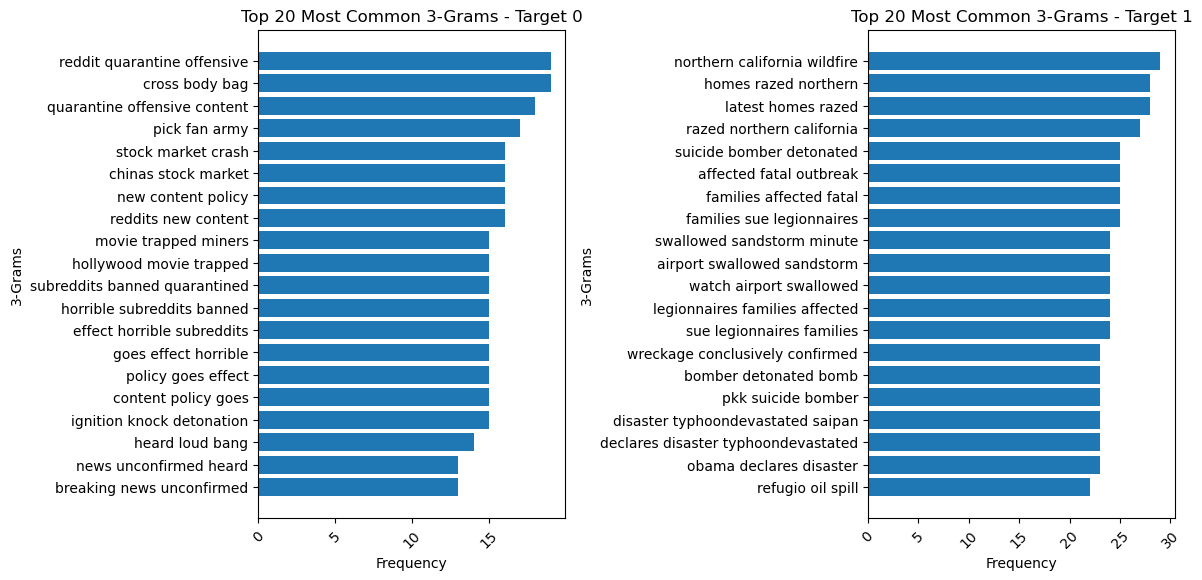

In [134]:
import matplotlib.pyplot as plt
from collections import Counter

# Tách các từ trong cột "text" với target = 0 thành 3-gram
words_0 = train_df['text'][train_df["target"] == 0].str.split()
three_grams_0 = [word for sublist in words_0 for word in zip(sublist[:-2], sublist[1:-1], sublist[2:])]
all_three_grams_0 = [' '.join(gram) for gram in three_grams_0]
three_gram_counts_0 = Counter(all_three_grams_0)
top_20_three_grams_0 = three_gram_counts_0.most_common(20)
three_gram_list_0, three_gram_count_0 = zip(*top_20_three_grams_0)
three_gram_list_0, three_gram_count_0 = zip(*sorted(zip(three_gram_list_0, three_gram_count_0), key=lambda x: x[1], reverse=False))

# Tách các từ trong cột "text" với target = 1 thành 3-gram
words_1 = train_df['text'][train_df["target"] == 1].str.split()
three_grams_1 = [word for sublist in words_1 for word in zip(sublist[:-2], sublist[1:-1], sublist[2:])]
all_three_grams_1 = [' '.join(gram) for gram in three_grams_1]
three_gram_counts_1 = Counter(all_three_grams_1)
top_20_three_grams_1 = three_gram_counts_1.most_common(20)
three_gram_list_1, three_gram_count_1 = zip(*top_20_three_grams_1)
three_gram_list_1, three_gram_count_1 = zip(*sorted(zip(three_gram_list_1, three_gram_count_1), key=lambda x: x[1], reverse=False))

# Vẽ biểu đồ subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ cho target = 0
axes[0].barh(three_gram_list_0, three_gram_count_0)
axes[0].set_title('Top 20 Most Common 3-Grams - Target 0')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('3-Grams')
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ cho target = 1
axes[1].barh(three_gram_list_1, three_gram_count_1)
axes[1].set_title('Top 20 Most Common 3-Grams - Target 1')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('3-Grams')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [122]:
train_df.to_csv('train_preprocessing.csv')
test_df.to_csv('test_preprocessing.csv')